In [1]:
def normalize_dict(d):
    s = sum(d.values())
    return {k: v / s for k, v in d.items()}

In [2]:
import numpy as np

# Generate synthetic sample
P = {
    "ABCD": 200,
    "ABC": 200,
    "BCD": 50,
    "BC": 50,
    "CD": 100,
    "C": 100,
    "AB": 200,
    "B": 100,
    "A": 50,
}
keys = list(P.keys())
values = list(P.values())
probs = [v / sum(values) for v in values]

In [3]:
import networkx as nx

N_T = sum(values)
G = nx.DiGraph()
G.add_nodes_from([(k, {"layer": len(k)}) for k in keys])
for key1 in keys:
    for key2 in keys:
        if key2.startswith(key1) or key2.endswith(key1):  # key 1 = ABC, key 2 = ABCD
            if key1 == key2:
                G.add_edge(key2, key1, weight=1)  # self prob = 1 first
            else:
                G.add_edge(key2, key1, weight=0)
G.edges(data=True)

OutEdgeDataView([('ABCD', 'ABCD', {'weight': 1}), ('ABCD', 'ABC', {'weight': 0}), ('ABCD', 'BCD', {'weight': 0}), ('ABCD', 'CD', {'weight': 0}), ('ABCD', 'AB', {'weight': 0}), ('ABCD', 'A', {'weight': 0}), ('ABC', 'ABC', {'weight': 1}), ('ABC', 'BC', {'weight': 0}), ('ABC', 'C', {'weight': 0}), ('ABC', 'AB', {'weight': 0}), ('ABC', 'A', {'weight': 0}), ('BCD', 'BCD', {'weight': 1}), ('BCD', 'BC', {'weight': 0}), ('BCD', 'CD', {'weight': 0}), ('BCD', 'B', {'weight': 0}), ('BC', 'BC', {'weight': 1}), ('BC', 'C', {'weight': 0}), ('BC', 'B', {'weight': 0}), ('CD', 'CD', {'weight': 1}), ('CD', 'C', {'weight': 0}), ('C', 'C', {'weight': 1}), ('AB', 'AB', {'weight': 1}), ('AB', 'B', {'weight': 0}), ('AB', 'A', {'weight': 0}), ('B', 'B', {'weight': 1}), ('A', 'A', {'weight': 1})])

In [4]:
def generate_guess(G, keys, N_T):
    longest_key = sorted(keys, key=len)[-1]
    p_generated = {key: 0 for key in keys}
    """
    Starting from the longest key
    get random choice from out edges (weighted)
    if random choice == longest key
        p_generated[longest key] += 1
    else:
        get new random choice from out edges of random choice.
        if new random choice == random choice
            p_generated[random_choice] += 1
        repeat
    """
    for _ in range(N_T):
        sequence = longest_key
        next_edge = None
        while True:
            out_edges = G.out_edges(sequence, data=True)
            weights = np.array([weight["weight"] for _, _, weight in out_edges])
            edges_to = [edge_to for _, edge_to, _ in out_edges]
            next_edge = np.random.choice(edges_to, p=weights)
            if next_edge == sequence:
                break
            sequence = next_edge

        p_generated[sequence] += 1
    return p_generated


p_generated = generate_guess(G, keys, N_T)
p_generated

{'ABCD': 1050,
 'ABC': 0,
 'BCD': 0,
 'BC': 0,
 'CD': 0,
 'C': 0,
 'AB': 0,
 'B': 0,
 'A': 0}

In [5]:
def KL(a, b):
    a = np.asarray(list(a))
    b = np.asarray(list(b))
    a = 1e-8 + a / np.sum(a)
    b = 1e-8 + b / np.sum(b)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))


kl = KL(P.values(), p_generated.values())

lr = 0.001  # learning rate


# time to update the graph G
def update_weights(G, kl, p_hat, p_generated, lr, verbose=False):
    p_hat = normalize_dict(p_hat)
    p_generated = normalize_dict(p_generated)
    for key in keys:
        out_edges = G.out_edges(key, data=True)
        for _, target, weight in out_edges:
            if key == target:
                continue
            source_copy_number = p_hat[key]
            target_copy_number = p_hat[target]
            generated_target_copy_number = p_generated[target]
            diff = source_copy_number * (
                target_copy_number / (generated_target_copy_number + 0.1)
            )

            add_to_weight = diff * lr * kl

            if np.abs(len(key) - len(target)) == 1:
                add_to_weight *= 2

            new_weight = max(
                0, weight["weight"] + add_to_weight
            )  # weight cannot be less than 0

            nx.set_edge_attributes(G, {(key, target): {"weight": new_weight}})
        total_out = sum([data["weight"] for s, t, data in out_edges])
        for key, target, data in out_edges:
            nx.set_edge_attributes(
                G, {(key, target): {"weight": data["weight"] / total_out}}
            )
    return G


G = update_weights(G, kl, P, p_generated, lr)

In [6]:
# The loop

lr = 0.1

generated = {}
kls = []
# given P
for i in range(100):
    # p_hat = sample(keys, probs, n_sample)
    p_generated = generate_guess(G, keys, N_T)
    generated[i] = p_generated
    kl = KL(P.values(), p_generated.values())
    G = update_weights(G, kl, P, p_generated, lr)
    kls.append(kl)
    weight_sum = sum([weight["weight"] for _, _, weight in G.edges(data=True)])

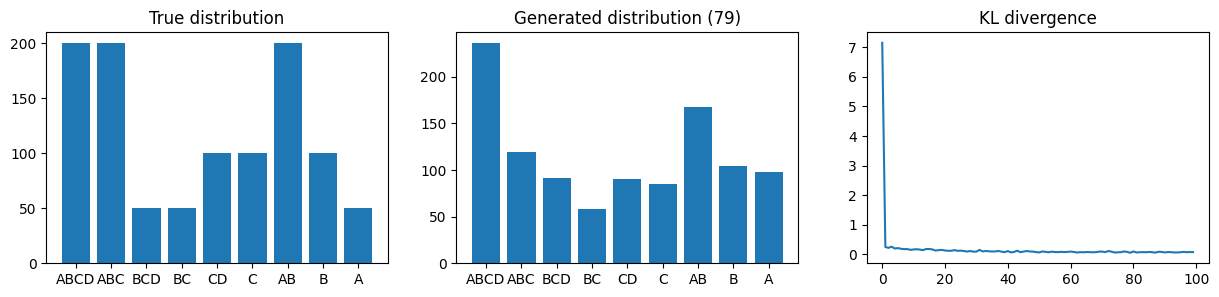

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 3))
p_generated = generated[list(generated.keys())[np.argmin(kls)]]
axs[0].bar(P.keys(), P.values())
axs[1].bar(p_generated.keys(), p_generated.values())
axs[2].plot(kls)
axs[0].set_title("True distribution")
axs[1].set_title(f"Generated distribution ({np.argmin(kls)})")
axs[2].set_title("KL divergence")
plt.show()

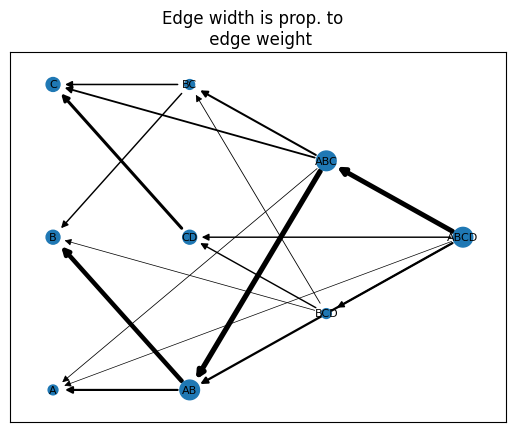

In [8]:
def draw_weighted_network(G, p_generated):
    pos = nx.multipartite_layout(G, subset_key="layer")
    node_size = [p_generated[s] for s in G.nodes()]
    nx.draw_networkx_nodes(G, pos=pos, node_size=node_size)
    nx.draw_networkx_labels(G, pos=pos, font_size=8)
    edge_width = [weight["weight"] * 10 for f, _, weight in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos=pos, width=edge_width)
    plt.title("Edge width is prop. to  \n edge weight")


no_self_G = nx.DiGraph()  # remove the self connections
for n, data in G.nodes(data=True):
    no_self_G.add_node(n, **data)
for s, t, data in G.edges(data=True):
    if s != t:
        no_self_G.add_edge(s, t, **data)

draw_weighted_network(no_self_G, P)

In [9]:
G.edges(data=True)

OutEdgeDataView([('ABCD', 'ABCD', {'weight': 0.22231736179946415}), ('ABCD', 'ABC', {'weight': 0.35541381693986085}), ('ABCD', 'BCD', {'weight': 0.10520528814587282}), ('ABCD', 'CD', {'weight': 0.10379107165773982}), ('ABCD', 'AB', {'weight': 0.1639856268375417}), ('ABCD', 'A', {'weight': 0.049286834619520485}), ('ABC', 'ABC', {'weight': 0.2881434821889539}), ('ABC', 'BC', {'weight': 0.14583493405888145}), ('ABC', 'C', {'weight': 0.13138806790430146}), ('ABC', 'AB', {'weight': 0.3782073495056065}), ('ABC', 'A', {'weight': 0.05642616634225657}), ('BCD', 'BCD', {'weight': 0.7850579188181803}), ('BCD', 'BC', {'weight': 0.06021462168167783}), ('BCD', 'CD', {'weight': 0.10271389408636235}), ('BCD', 'B', {'weight': 0.05201356541377948}), ('BC', 'BC', {'weight': 0.7843007295489864}), ('BC', 'C', {'weight': 0.11165902164400343}), ('BC', 'B', {'weight': 0.10404024880701015}), ('CD', 'CD', {'weight': 0.7780038502184563}), ('CD', 'C', {'weight': 0.22199614978154375}), ('C', 'C', {'weight': 1.0}),

In [10]:
from disassembly.disassembly import get_disassembly_indexes

disassembly_indexes = get_disassembly_indexes(no_self_G)
print(disassembly_indexes)
from disassembly.disassembly import get_disassembly

get_disassembly(P, disassembly_indexes)

{'ABCD': 0, 'ABC': 1.0, 'BCD': 1.0, 'BC': 2.0, 'CD': 1.4973918845789105, 'C': 2.4775429168116356, 'AB': 1.697551178284248, 'B': 2.6875727072048745, 'A': 2.2259833282092285}


5.573744140167984